# Preregistration: Evaluation of Clinical Benefit

Gaylen Fronk  
April 23, 2024

In [ ]:
study <- params$study
version <- params$version
algorithms <- params$algorithms


In [ ]:

# packages for script
library(lme4)


Loading required package: Matrix

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.9
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.4.4     ✔ tidyr        1.3.1
✔ infer        1.0.6     ✔ tune         1.1.2
✔ modeldata    1.3.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard()  masks scales::discard()
✖ tidyr::expand()   masks Matrix::expand()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ tidyr::pack()     masks Matrix::pack()
✖ recipes::step()   masks stats::step()
✖ tidyr::unpack()   masks Matrix::unpack()
✖ recipes::update() masks Matrix::update(), stats::update()
• Learn how to get started at https://www.tidymodels.org/start/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ readr::spec()       masks yardstick::spec()
✖ tidyr::unpack()     masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "bb7bddab14e337e74cb65ad3b94d58a2492d34cd"

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")


In [ ]:

# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- "P:/studydata/match/models"},
        
        # IOS paths
        Darwin = {
          path_models <- "/Volumes/private/studydata/match/models"},
        
        # Linux paths
        Linux = {
          path_models <- "~/mnt/private/studydata/match/models"}
)


In [ ]:

# chunk defaults
knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


In [ ]:

# read in d for week 4 model
d_wk4 <- read_csv(file.path(path_models, "pp_hybrid_wk4_outcome", 
                        str_c("aim_2_", version, "_pp_hybrid_wk4_outcome.csv")),
              show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  mutate(tx_rank = case_when(
    tx_rct == tx_best ~ "first",
    tx_rct == tx_second ~ "second",
    tx_rct == tx_worst ~ "third",
    TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) 

# read in best_config for week 4 model
best_configuration_wk4 <- read_csv(file.path(path_models, "pp_hybrid_wk4_outcome",
                                         str_c("best_config_", version, ".csv")),
                               show_col_types = FALSE) |> 
  select(algorithm, feature_set, alpha = hp1, lambda = hp2, resample)

# read in d for week 26 model
# d_wk26 <- read_csv(file.path(path_models, "pp_hybrid_wk26_outcome", 
#                         str_c("aim_2_", version, "_pp_hybrid_wk26_outcome.csv")),
#               show_col_types = FALSE) |> 
#   mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
#          outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
#          outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
#          tx_worst = case_when(
#            prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
#            prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
#            prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
#            TRUE ~ NA_character_),
#          tx_second = case_when(
#            tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
#            tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
#            tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
#            tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
#            tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
#            tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
#            TRUE ~ NA_character_)) |> 
#   mutate(tx_rank = case_when(
#     tx_rct == tx_best ~ "first",
#     tx_rct == tx_second ~ "second",
#     tx_rct == tx_worst ~ "third",
#     TRUE ~ NA_character_)) |> 
#   select(subid, starts_with("tx_"), starts_with("prob_"),
#          outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) 

# read in best_config for week 26 model
best_configuration_wk26 <- read_csv(file.path(path_models, "pp_hybrid_wk26_outcome",
                                         str_c("best_config_", version, ".csv")),
                               show_col_types = FALSE) |> 
  select(algorithm, feature_set, learning_rate = hp1, tree_depth = hp2, 
         mtry = hp3, resample)


In [ ]:

# make figure for john's presentation
d_fig <- d_wk4 |> 
  select(subid, tx_rank, 
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(tx_rank = factor(tx_rank, 
                          levels = c("first", "second", "third")),
         week = factor(week,
                       levels = c("wk4", "wk12", "wk26")),
         subid = factor(subid)) |> 
  summarize(outcome_mean = mean(outcome_rct_num), .by = c(tx_rank, week)) 

# bar chart
d_fig |> 
  ggplot(aes(x = week, y = outcome_mean, fill = tx_rank)) +
  geom_col(position = "dodge") 


## Study Overview

### Specific Aims

This project represents a tangible application of the precision mental health paradigm using modern machine learning approaches. This project aims to produce a decision-making tool to select among cigarette smoking cessation treatments for individuals looking to quit smoking.

Cigarette smoking remains a critical and costly public health crisis. Existing treatments are only modestly effective at best. Additionally, treatments are similarly effective at the population level, meaning that even population-level effectiveness cannot guide treatment selection for individuals quitting smoking. Thus, deciding among first-line (i.e., FDA-approved) smoking cessation medications is a specific, objective decision that many individuals who smoke (or their providers) must make. Successful application of the precision mental health paradigm to cigarette smoking cessation would have immediate clinical benefit.

Specifically, this project pursues the following aims:

**AIM 1: Build a machine learning model to guide treatment selection for cigarette smoking cessation.** We will build a machine learning model to predict treatment success (i.e., point-prevalence abstinence from smoking) for people who smoke who received one of three cigarette smoking cessation treatments. This model will use clinical features (predictors) from a richly characterized sample of people who smoke from a previously completed randomized controlled trial. The model will produce probabilities of treatment success for each treatment such that it can guide selection of the best treatment for any specific individual.

**AIM 2: Evaluate the clinical benefit of using a treatment selection machine learning model.** Using the best model identified in **AIM 1**, we will identify the treatment for each person that gives them the highest likelihood of abstinence by comparing predicted probabilities of abstinence for each participant for each treatment. We will then evaluate the clinical benefit of this model-based treatment selection approach.

### Data

This project relies on existing data from a completed comparative effectiveness trial by [Baker et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4824537/). Briefly, 1086 individuals who smoke cigarettes were randomized to receive varenicline, combination nicotine replacement therapy (NRT), or nicotine patch to assist with a quit attempt. Individuals were richly characterized at baseline (pre-treatment) with respect to demographic characteristics, mental health, social/environmental variables, physical health, and smoking history. Participants were assessed periodically for biologically confirmed, 7-day point-prevalence abstinence. When abstinence was biologically confirmed (i.e., via exhaled carbon monoxide), individuals were labeled as abstinent; otherwise, individuals were labeled as smoking.

## Analysis Progress at Time of Preregistration

### Completed: Model Building, Selection, & Evaluation

**AIM 1** analyses have been completed: Models using all available data have been fit and selected with nested cross-validation (1 repeat of 10-fold cross-validation in the inner loops, 3 repeats of 10-fold cross-validation in the outer loop). These 30-held out folds (“test sets”) were used to evaluate model performance.

Models have been fit using two outcomes:

-   Week 4 7-day point-prevalance abstinence

-   Week 26 (60 month) 7-day point-prevalence abstinence

A single, best model for each outcome was selected with 1 repeat of 10-fold cross-validation in the full dataset.

The best model configuration for the **Week 4 outcome** includes the following:

In [ ]:
glimpse(best_configuration_wk4)


Rows: 1
Columns: 5
$ algorithm   <chr> "glmnet"
$ feature_set <chr> "item_ordinal"
$ alpha       <dbl> 0.1
$ lambda      <dbl> 0.1326421
$ resample    <chr> "up_1"

-   Selected algorithm was glmnet (xgboost and random forest also considered)

-   Selected feature set was “item_ordinal” indicating that individual items (rather than scale scores) were used, and ordinal scoring was used for ordered data (rather than dummy coding)

-   Selected resampling approach was “up_1” corresponding to upsampling (vs. downsampling or SMOTE) with a ratio of 1:1 (majority:minority class)

-   Values of the hyperparameters alpha and lambda were selected from sensible ranges for each value

The best model configuration for the **Week 26 outcome** includes the following:

In [ ]:
glimpse(best_configuration_wk26)


Rows: 1
Columns: 6
$ algorithm     <chr> "xgboost"
$ feature_set   <chr> "item_knn_5"
$ learning_rate <dbl> 0.01
$ tree_depth    <dbl> 3
$ mtry          <dbl> 50
$ resample      <chr> "up_1"

-   Selected algorithm was UPDATE (xgboost and random forest also considered)

-   Selected feature set was “UPDATE” indicating that individual items (rather than scale scores) were used, and ordinal scoring was used for ordered data (rather than dummy coding)

-   Selected resampling approach was “UPDATE” corresponding to upsampling (vs. downsampling or SMOTE) with a ratio of 1:1 (majority:minority class)

-   Values of the hyperparameters UPDATE were selected from sensible ranges for each value

### Completed: Model Performance

Models were evaluated using our primary performance metric, area under the ROC curve (auROC), an index of how well our models discriminate between positive (abstinent) and negative (smoking) cases.

We evaluated model performance in-depth by conducting *Bayesian hierarchical generalized linear models* to estimate the posterior probability distributions and 95% Bayesian credible intervals (CIs) for auROC for our best models from the 30 held-out test sets from nested cross-validation. Below, you can see the posterior probabilities for auROC for our week 4 (top panel) and week 26 (bottom panel) models.

``` python
fig_posteriors <- pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_26"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y + 100, yend = y - 100, x = mean, xend = mean,
                             color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper, color = model),
               data = ci) +
  facet_wrap(~model, ncol = 1) +
  scale_y_continuous("Posterior Probability", breaks = c(0, 500, 1000)) +
  # ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve")

fig_posteriors
```

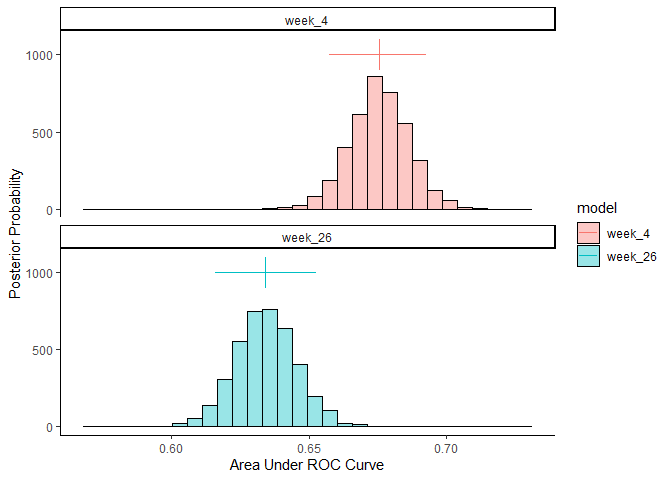

The horizontal line indicates the 95% CIs. The vertical line represents the median posterior probability for auROC. This represents our best estimate for the magnitude of the auROC parameter for each model. These CIs do not contain 0.5 (i.e., chance performance), suggesting both models are capturing signal in the data.

*Because both models have predictive value as evidenced by these Bayesian analyses, we will conduct AIM 2 analyses with both models.*

### In Progress: AIM 2 Clinical Benefit Analyses

**AIM 2** analyses using this full model are underway. Here, we walk through our process using the data for only the week 4 model; however, the data structure and process are identical for the week 26 model.

We have used the final models (for each outcome) fit in the full dataset to generate three predictions (probabilities, `prob_*`) for each participant by substituting each treatment into the model inputs. Thus, there is one prediction per person per treatment.

In [ ]:
set.seed(82294)
d_wk4 |> 
  select(subid, prob_patch, prob_combo_nrt, prob_varenicline) |> 
  slice_sample(n = 8) |> 
  print_kbl(digits = 3)


The treatment that yields the highest model-predicted probability of abstinence is identified as that participant’s “best” treatment (`tx_best`).

In [ ]:
d_wk4 |> 
  select(subid, tx_best, prob_patch, prob_combo_nrt, prob_varenicline) |> 
  slice_sample(n = 8) |> 
  print_kbl(digits = 3)


The best treatments spanned all three medication options: varenicline, combination nicotine replacement therapy (“combo_nrt”), and nicotine patch (“patch”).

In [ ]:
d_wk4 |> 
  tab(tx_best)


# A tibble: 3 × 3
  tx_best         n  prop
  <chr>       <int> <dbl>
1 combo_nrt     339 0.312
2 patch         193 0.178
3 varenicline   554 0.510

Some participants’ best treatment (`tx_best`) matched what they were randomly assigned in the original trial (`tx_rct`). Other participants may have received what the model identified as their second-best or worst treatment. Thus, participants’ RCT-assigned treatment can be categorized by whether it “matched” their model-assigned treatment (`tx_match`).

In [ ]:
d_wk4 |> 
  select(subid, tx_match, tx_rct, tx_best, tx_second, tx_worst) |> 
  slice_sample(n = 10) |> 
  print_kbl()


Just over one third of participants received their model-assigned “best” treatment in the original trial.

In [ ]:
d_wk4 |> 
  tab(tx_match)


# A tibble: 2 × 3
  tx_match     n  prop
  <lgl>    <int> <dbl>
1 FALSE      677 0.623
2 TRUE       409 0.377

## Purpose of Preregistration

The purpose of this document is to **preregister the analyses for evaluating the clinical benefit of this treatment selection model**.

Our primary analysis will compare the observed outcomes (i.e., abstinence vs. smoking, from the original trial) for people who did or did not receive their best treatment. We will examine these outcomes over the following time points:

-   4 weeks: This time point served as an outcome for a prediction model. This selection was made so that, in real-world implementation, treatment could be adjusted earlier for individuals for whom treatment is not working.

-   12 weeks: This is end-of-treatment and represents a mid-point between the early (4-week) and later (26-week) outcomes.

-   26 weeks (6 months): This time point served as an outcome for a prediction model. This is the gold standard assessment period for smoking cessation treatments and was the primary outcome for the original trial ([Baker et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4824537/)). This duration is often used as a proxy for long-term success.

Thus, our model will have the following components:

1.  Dependent variable: abstinence (vs. smoking; `outcome_rct_num`). Binary outcome with abstinence coded as 1 and smoking coded as 0.

2.  Independent variable: treatment match (`tx_match`). Between-subjects categorical variable with two levels (TRUE or FALSE). This variable will be coded with an orthogonal contrast such that we compare individuals who received their best treatment to individuals who did not.

3.  Independent variable: time (`week`). Within-subjects categorical variable with three levels (week 4, week 12, week 26). This variable will be coded with orthogonal Helmert contrasts to avoid making an assumption about the linearity of this effect. We will compare the earliest 4-week outcome to the two later outcomes, and the 12-week outcome to the 26-week (6 month) outcome.

4.  Interaction between treatment match and time

5.  Random slope for time (3 repeated observations of time for each subject)

6.  Random intercept

We plan to follow a mixed-effects modeling approach using the `lme4` package. Specifically, we will fit a generalized linear model using `glmer()` with the components listed above.

Our **focal effect** is the effect of treatment match. We predict that individuals who received their best treatment will have improved outcomes compared to individuals who did not.

Our **secondary effects** include:

-   The interactions between treatmennt match and both time contrasts (week 4 vs. later, week 12 vs. week 26). We do not have directional hypotheses about these interactions.

    -   If either of these interactions are significant (*p* \< 0.05), we will conduct **follow-up tests** of the simple effect of the best vs. other treatment contrast at all 3 time points (week 4, week 12, and week 26).

Although the above estimates comprise our focal effects, we plan to report the estimates, test statistics, *p*-values, and confidence intervals for all fixed effects from this model.

## Shuffle Data

To ensure that all proposed analyses are feasible and to specify analyses as precisely as possible, the remainder of this document conducts analyses using our data with shuffled outcome variables. Following preregistration, our analyses will follow this script exactly using our real data.

*Again, we will walk through this process using shuffled data from our week 4 model, but the process will be identical for our week 26 model.*

To create this shuffled dataset, we:

-   break the relationship between treatment match and outcome by sampling (without replacement) the treatment match variable (`tx_match`)

-   pivot into long format with week as a within-subjects factor

-   remove unnecessary variables

In [ ]:
set.seed(72905)
d_shuf <- d_wk4 |> 
  select(subid, tx_match, 
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  mutate(tx_match = sample(d_wk4$tx_match, nrow(d_wk4), replace = FALSE)) |>
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_wk)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(tx_match = factor(tx_match, 
                          levels = c(FALSE, TRUE)),
         week = as.numeric(week)) |> 
  mutate(week_log = log(week)) |> 
  mutate(week_log_scale = scale(week_log)[,1])

glimpse(d_shuf)


Rows: 3,258
Columns: 6
$ subid           <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 20030…
$ tx_match        <fct> TRUE, TRUE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ week            <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26,…
$ outcome_rct_num <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, …
$ week_log        <dbl> 1.386294, 2.484907, 3.258097, 1.386294, 2.484907, 3.25…
$ week_log_scale  <dbl> -1.2890446, 0.1412207, 1.1478239, -1.2890446, 0.141220…

Confirm that data look random

In [ ]:
d_shuf |> 
  group_by(week, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num)) 


`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.

# A tibble: 6 × 3
# Groups:   week [3]
   week tx_match mean_outcome
  <dbl> <fct>           <dbl>
1     4 FALSE           0.349
2     4 TRUE            0.330
3    12 FALSE           0.290
4    12 TRUE            0.291
5    26 FALSE           0.244
6    26 TRUE            0.252

Set contrasts for week and treatment match

In [ ]:
# contrast coding on week
# c_week <- contr.helmert(c("wk26", "wk12", "wk4"))
# c_week[, 1] <- c_week[, 1] / (max(c_week[, 1]) - min(c_week[, 1]))
# c_week[, 2] <- c_week[, 2] / (max(c_week[, 2]) - min(c_week[, 2]))
# colnames(c_week) <- c("wk12_v_wk26", "wk4_v_later")
# contrasts(d_shuf$week) <- c_week
# contrasts(d_shuf$week)

# contrast coding on treatment match
c_tx <- contr.helmert(c(FALSE, TRUE))
c_tx[, 1] <- c_tx[, 1] / (max(c_tx[, 1]) - min(c_tx[, 1]))
colnames(c_tx) <- c("best_v_other")
contrasts(d_shuf$tx_match) <- c_tx
contrasts(d_shuf$tx_match)


      best_v_other
FALSE         -0.5
TRUE           0.5

## Analysis Steps

### Primary Model

In [ ]:
model_1 <- glmer(outcome_rct_num ~ tx_match * week_log + (1 + week_log | subid),
                       data = d_shuf,
                       family = binomial(link = "logit"),
                 control = glmerControl(optCtrl = list(maxfun = 3e6)))


Warning in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
Model failed to converge with max|grad| = 0.0166072 (tol = 0.002, component 1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: outcome_rct_num ~ tx_match * week_log + (1 + week_log | subid)
   Data: d_shuf
Control: glmerControl(optCtrl = list(maxfun = 3e+06))

     AIC      BIC   logLik deviance df.resid 
  3090.4   3133.1  -1538.2   3076.4     3251 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.28497 -0.42787 -0.06827  0.14552  1.45809 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 subid  (Intercept) 10.58    3.253         
        week_log    12.93    3.595    -1.00
Number of obs: 3258, groups:  subid, 1086

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     1.9798     0.3412   5.803 6.53e-09 ***
tx_matchbest_v_other           -0.3267     0.3963  -0.824     0.41    
week_log                       -2.2200     0.2197 -10.103  < 2e-16 ***
tx_matchbest_v_other:week_log   0.1215 

### Alternative Models for Robustness Checks

The model fit above has a singular fit. There are a number of recommended approaches to address singular fits (see `?isSingular`) if the model fit with our real data also has a singular fit.

For consistency, the following proposed alternative approaches mirror the steps we followed in a previously published project from our laboratory that also required complex mixed-effects modeling ([Schultz et al., 2022](https://psycnet.apa.org/record/2022-10249-001)). These steps are available in our open-access, annotated analysis scripts (e.g., [this script](https://osf.io/k8gfc)).

1.  Use a partially Bayesian method that uses regularizing priors to force the estimated random effects variance-covariance matrices away from singularity ([Chung et al., 2013](https://link.springer.com/article/10.1007/s11336-013-9328-2), `blme` package). We would use the `"nlminbwrap"` optimizer because `"bobyqa"` produced a singular fit.

In [ ]:
model_2 <- blme::bglmer(outcome_rct_num ~ tx_match * week_log + (1 + week_log | subid),
                        data = d_shuf,
                        family = binomial(link = "logit"),
                        control = glmerControl(optCtrl = list(maxfun = 3e6)))


1.  Use a simpler random effects structure to address problems with singular fits. Following this strategy, we would fit a model with only the random intercept.

In [ ]:
model_3 <- lme4::glmer(outcome_rct_num ~ tx_match * week + (1 | subid),
                       data = d_shuf,
                       family = binomial(link = "logit"),
                       control = glmerControl(optimizer = "bobyqa",
                                              optCtrl = list(maxfun = 3e6)))


1.  Re-fit the glmer model with the full random effects structure across all available optimizers and review for consistency of log-likelihood ratios, fixed effects, and test statistics of focal effect across optimizers.

In [ ]:
opts <- tibble(optimizer = c("bobyqa", "Nelder_Mead", "nlminbwrap", 
                             "nmkbw", "optimx", "nloptwrap", "nloptwrap"),
               method = c("", "", "", "", "L-BFGS-B", 
                          "NLOPT_LN_NELDERMEAD", "NLOPT_LN_BOBYQA")) %>% 
  as.data.frame()

model_all <- allFit(model_1, verbose = FALSE, meth.tab = opts)


In [ ]:

# Review warning/error messages across remaining optimizers
effects <- tidy_opts(model_all, terms = "tx_rankbest_v_other")
opt_names <- names(effects$msg)
effects$msg |> 
  map2_dfr(opt_names, extract_opts_msgs)

# confirm that log-likelihood ratios are equivalent across optimizers
effects |> 
  filter(term == "model") |> 
  select(optimizer, llik)

# Confirm fixed effects & test stats are equivalent across optimizers for our focal effect (best treatment vs. other)
effects |> 
  filter(term == "tx_rankbest_v_other") |> 
  select(-msg, -llik)


### Follow-up analyses: Simple Effects

If either interaction for our secondary outcomes (best vs. other treatment rank contrast X both time contrasts) is significant (*p* \< 0.05), we will conduct follow-up analyses to test the simple effect of the best vs. other treatment rank contrast at each time point.

Simple effect at 4 weeks

In [ ]:
d_4_shuf <- d_shuf |> 
  filter(week == "wk4")

model_4wk <- glm(outcome_rct_num ~ tx_match, 
                 data = d_4_shuf,
                 family = binomial(link = "logit"))

summary(model_4wk)


Simple effect at 12 weeks

In [ ]:
d_12_shuf <- d_shuf |> 
  filter(week == "wk12")

model_12wk <- glm(outcome_rct_num ~ tx_match, 
                  data = d_12_shuf,
                  family = binomial(link = "logit"))

summary(model_12wk)


Simple effect at 26 weeks

In [ ]:
d_26_shuf <- d_shuf |> 
  filter(week == "wk26")

model_26wk <- glm(outcome_rct_num ~ tx_match, 
                  data = d_26_shuf,
                  family = binomial(link = "logit"))

summary(model_26wk)
